# League of Legends Professional Game Data
## LSTM Neural Network to Predict Game Wins/Losses
## Michael Phillips

In [108]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
%matplotlib inline

## League of Legends Professional Game Data

Running the following cell will utilize a Python script that takes raw game data and returns properly formatted 3D arrays suitable for an LSTM network.

In [109]:
%run data_formatting.py

X_train shape:  (169440, 10, 22)
y_train shape:  (169440,)
X_test shape:  (42345, 10, 22)
y_test shape:  (42345,)


### Explanation of the data:
- The table below shows the final data formatting. 'match_id' denotes the game, and whether the team was on red or blue side of the game map. Each row is a snapshot of game statistics at that moment in time. There is one row per minute, per team, per game, counting upwards until the game ends. 


- The data was scaled in the previous script. The table visible here shows the unscaled data, which is a bit more intuitive to look at.


- Each sample (169,440 in the training set) is comprised of ten minute segments of game time. The first sample for the game below would consist of 'time' 0 through 9, the second sample would be 'time' 1 through 10, and so on until the game ends.


- There were a little over 3000 total games in the data set. Splitting the games into red and blue side and then segmenting into ten minute chunks resulted in the total samples used to train and test the neural network.


- Data wrangling steps undertaken for this model are detailed in the notebooks 'Feature Generation' and 'Feature_generation_pt_2' found within this repository.

In [107]:
df.head(10)

,match_id,time,gold,top_gold,jgl_gold,mid_gold,adc_gold,sup_gold,kill_total,assist_total,opp_kill_total,opp_assist_total,r_inhib_count,r_baron_count,r_tower_count,r_herald_count,r_drag_count,b_inhib_count,b_baron_count,b_tower_count,b_herald_count,b_dragon_count,kda,opp_kda,result
0,001a1f289e3bab22_b,0.0,2415.0,475.0,475.0,475.0,475.0,515.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,001a1f289e3bab22_b,1.0,2430.0,475.0,475.0,475.0,475.0,530.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,001a1f289e3bab22_b,2.0,2751.0,532.0,552.0,532.0,532.0,603.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,001a1f289e3bab22_b,3.0,3929.0,849.0,817.0,791.0,686.0,786.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,001a1f289e3bab22_b,4.0,5219.0,1099.0,1099.0,1107.0,976.0,938.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
5,001a1f289e3bab22_b,5.0,6418.0,1466.0,1278.0,1352.0,1196.0,1126.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00,1.5,0.0
6,001a1f289e3bab22_b,6.0,8156.0,1667.0,1708.0,1574.0,1687.0,1520.0,2.0,1.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,3.5,0.0
7,001a1f289e3bab22_b,7.0,9520.0,1970.0,2097.0,1708.0,1995.0,1750.0,2.0,1.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.00,3.5,0.0
8,001a1f289e3bab22_b,8.0,10681.0,2147.0,2414.0,1988.0,2244.0,1888.0,2.0,1.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.75,4.5,0.0
9,001a1f289e3bab22_b,9.0,12036.0,2605.0,2533.0,2321.0,2535.0,2042.0,2.0,1.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.75,4.5,0.0


## Model Training

### Explanation of the Model

- The data was formatted into a simple time series with the eventual goal of being able to predict game wins and losses at each minute. It was essential that the model be able to make connections between stats early in the game and later on. For these reasons a recurrent neural network was chosen, specifically an LSTM for its proven performance on time series problems.


- The final model constructed in the following cell was the result of extensive tuning. The final configuration that provided the best performance turned out to be: DENSE->DROPOUT->LSTM->OUTPUT. Other potential structures tested were LSTM->OUTPUT, and LSTM->DENSE->OUTPUT both with and without DROPOUT layers.


- Dropout was found to be a neccesary component of the model to alleviate overfitting as much as possible.


- Other parameters tuned include: neurons in each layer, dropout rates, weight constraint, batch size, and epoch.


- Model creation/tuning steps can be found in the notebooks 'data_formatting_for_neural_network' and 'data_formatting_for_NN_pt2' also available in this repository.

In [9]:
# create/compile model using previously optimized parameters
model = Sequential()
model.add(Dense(50,batch_input_shape=(4705, X_train[:-64].shape[1],X_train[:-64].shape[2]),
               kernel_constraint=maxnorm(1)))
model.add(Dropout(0.2))
model.add(LSTM(45, stateful=True))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',
         optimizer='rmsprop',
         metrics=['accuracy'])

In [10]:
# fit model on training data over 50 epochs
# store loss/accuracy scores in lists for plotting
loss = []
acc = []

for i in range(50):
    history = model.fit(X_train[:-64],y_train[:-64],batch_size=4705,shuffle=False,epochs=1,verbose=0)
    loss.append(history.history['loss'])
    acc.append(history.history['acc'])
    model.reset_states()

### Model Loss


- Loss is a measure of how well the model fits the data. It is expected to decrease with each epoch, and ideally to find a good stopping point before overfitting the training set.


- The below graph reflects this process. The overall trend is still downwards toward the final epochs, however continuing to train the model results in worse performance likely due to overfitting. A middle ground was decided upon such that the model learns the overall trends but stops learning prior to memorizing the training set.

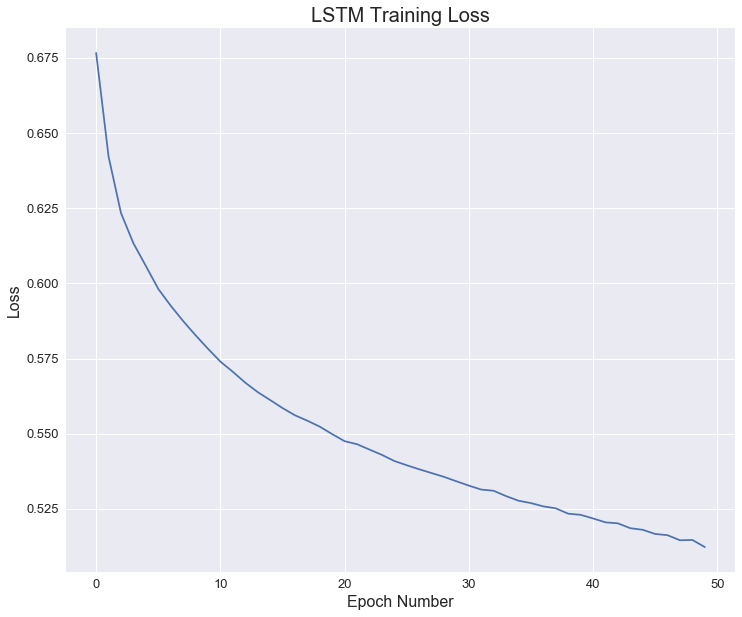

In [112]:
# create/format plot of model loss
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
plt.plot(loss);
plt.title("LSTM Training Loss",fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel("Epoch Number", fontsize=16)
plt.ylabel("Loss", fontsize=16);

### Model Accuracy


- Accuracy is a simple measure of how well the model functions. There are two classifications for this task (win or loss) so accuracy is determined by dividing the number of correct predictions by the total predictions.


- The below graph visualizes training accuracy. While the loss (model performance) goes down each epoch as neuron weights are updated, model accuracy goes up. The trend seen below shows the accuracy beginning to plateau, and a middle-ground was decided upon to ensure the model is as accurate as possible while still being able to generalize to data it has not seen in the test set.

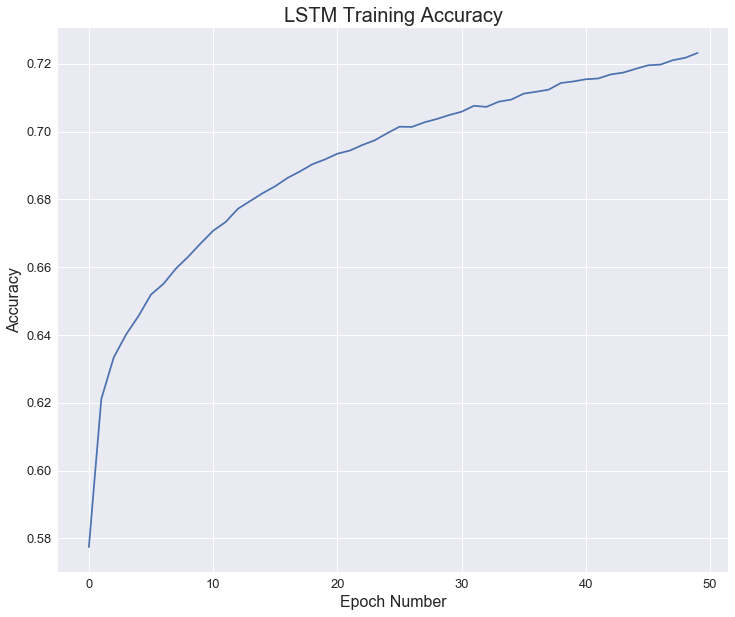

In [113]:
# create/format plot of model accuracy
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
plt.plot(acc);
plt.title("LSTM Training Accuracy",fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel("Epoch Number", fontsize=16)
plt.ylabel("Accuracy", fontsize=16);

## Model Results and Analysis

### Model Accuracy on the Test Set


- Final accuracy for the model on the test set was 64%. That is to say, for data the model has never seen it will accurately predict wins and losses 64% of the time. Baseline accuracy for this problem would be 50%, equivalent to flipping a coin to see which team would win a given game. 


### Analysis
64% accuracy is perhaps about as good as could be expected for this dataset. There were two main limitations of the data/model construction and one inherent aspect of League of Legends that led to this conclusion. 

#### Limitations of the data/model construction
- The dataset consisted of only ~3000 games. There are many thousands of League of Legends games played every day but that data is much harder to come by. Ideally, a model of this type could utilize most or all available game data.


- Computational power was limited. This project was completed using one desktop PC. While powerful in and of itself, it is no match for distributed computing available from services such as AWS. In a production environment distributed computing would lend itself to further refinement of parameter tuning, as well as allowing a much larger dataset to be used.

#### League of Legends Predictions

- As seen in professional sports where data science is a proven commodity, results vary by sport depending on inherent aspects of the game in question. As a gross oversimplification: basketball has more inherent randomness built into the game than baseball. For example, the bounce of the basketball off the rim towards one team or another in the final seconds of a game can decide a win/loss. Whereas with baseball, a win/loss is much more the result of what came before in the game and is readily quantified in statistics. The result: baseball is easier to create models for.


- LOL falls somewhere on this spectrum as well. There is skill that can be measured by statistics as was done here, but the randomness/luck that are inescapable also influences a game. LOL is complex with many different moving parts that all come together to decide a winner. Not all of those aspects of the game are represented within the data. 


- Data science relating to LOL has rapidly picked up recently with the influx of funding to professional teams. I expect descriptive statistics for LOL to evolve quickly, improving the performance of machine learning models on the game. For this project the goal was to utilize a neural network to solve a prediction problem, not necessarily to rewrite the book on LOL analysis.

In [111]:
# evaluate model using the test data
score = model.evaluate(X_test[:-31], y_test[:-31], verbose=0,batch_size=4705)
print("Model Loss: %.4f" % (score[0]))
print("Model Accuracy: %.2f%%" % (score[1]*100))

Model Loss: 0.6265
Model Accuracy: 63.96%


### Confusion Matrix 

- The confusion matrix below shows model accuracy. The split between accurate win predictions (1.0 below) and accurate loss predictions (0.0) was roughly equal across the data. A 'True' 0.0 and a predicted '0' means the model predicted correctly. A 'True' 0.0 and a predicted '1' means the model predicted incorrectly.

In [87]:
pd.crosstab(y_test[:-31].ravel(), y_pred.ravel(), rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0.0,13090,7881,20971
1.0,7379,13995,21374
All,20469,21876,42345


# Minute by Minute Win Probability 

## Introduction

The initial goal of this project was to do minute by minute predictions of which team would win the game. To demonstrate the model's ability to function in this way, the below example utilizes a game previously explored in the EDA portion of this project - Game 4 of the 2016 League of Legends World Championship between the teams SKT and Samsung Galaxy. This particular game was chosen because it was a back-and-forth game that was not decided until late in the match.

The graph below shows total gold values for each team for the game. There were several turning points in the game denoted by the shifting gold values.

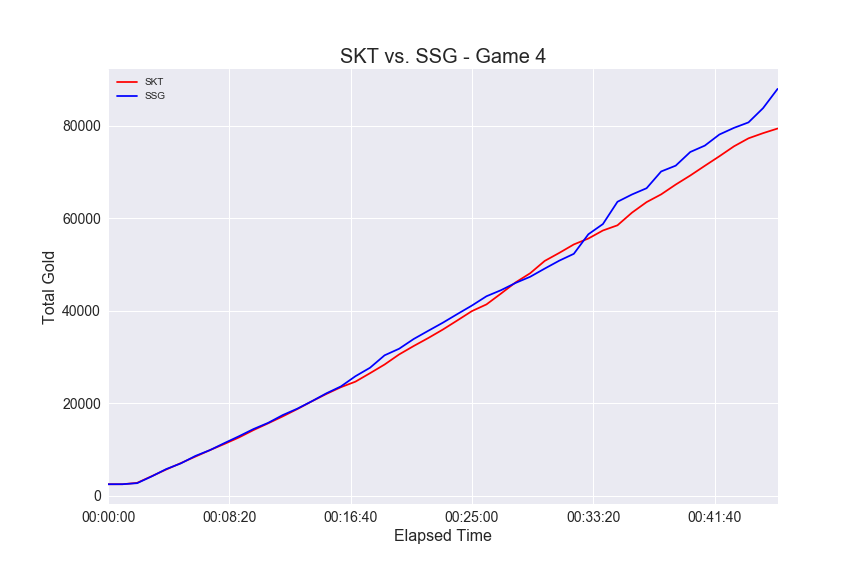

In [105]:
from IPython.display import Image
Image('game_4.png')

This graph shows gold differential. 0 means both teams had equal gold totals, while negative values denote SKT trailing behind SSG. The dotted lines show objective times (captured in the model data), and the red and blue markers show kills. A bigger marker means that multiple kills took place at that time point.

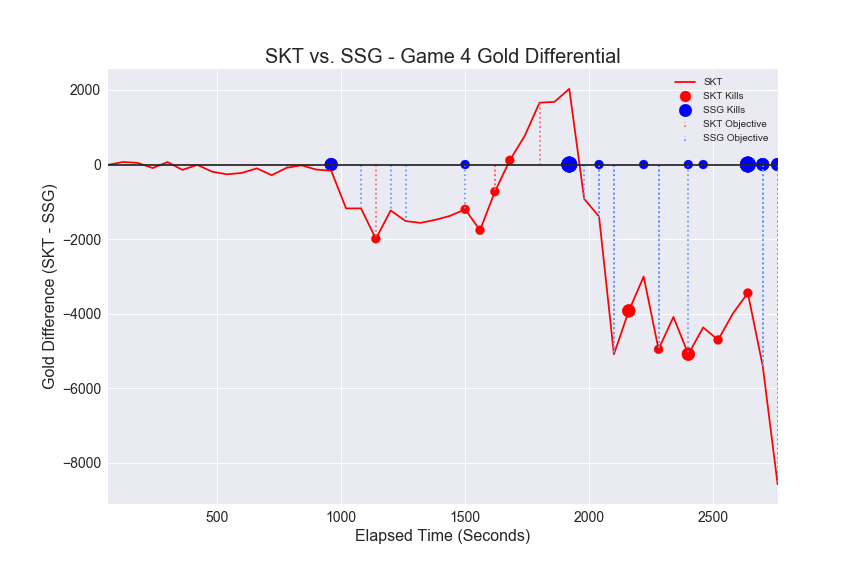

In [106]:
Image('game_4_diff.png')

### The model will need to be re-compiled to accept a batch size of 1.

In [115]:
# select and format game data for 2016 LOL Championship Game 4
%run game_four_formatting.py

In [100]:
# batch size reconfigured to 1 to predict minute by minute
batch_size_single_game = 1

# create new model with updated batch size
model2 = Sequential()
model2.add(Dense(50,batch_input_shape=(batch_size_single_game, X_train[:-64].shape[1],X_train[:-64].shape[2]),
               kernel_constraint=maxnorm(1)))
model2.add(Dropout(0.2))
model2.add(LSTM(45, stateful=True))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss='binary_crossentropy',
         optimizer='rmsprop',
         metrics=['accuracy'])

# use weights from previous model to seed new model
calc_weights = model.get_weights()
model2.set_weights(calc_weights)

In [101]:
# predict red teams win probabilities
ssg = model2.predict(xg2r,batch_size=batch_size_single_game)

# blue teams probabilities is 1 minus red probability
skt = 1 - red

In [102]:
# reformat for plot
# pad with 50% probability for first 10 minutes
ssg = ssg.ravel().tolist()
for i in range(10):
    ssg.insert(0,0.5)

skt = blue.ravel().tolist()
for i in range(10):
    skt.insert(0,0.5)

## Minute by Minute Prediction Plot

- The below graph shows predicted win percentages per team and per minute. The dotted gray line denotes the baseline expected win percentage of 50%. 


- The data was padded with the baseline win percentage for the first 10 minutes for two reasons. First, due to the structure of the model the first prediction is for minute 11. Second, in a professional setting it is close to impossible for a team to win in the first 10 minutes. In fact, the shortest recorded game in this dataset was around 18 minutes. This limitation is built into the game and made disregarding the first 10 minutes a reasonable choice for simplifying the model. 


- Comparing the plot below to the plots shown previously, it is clear how expected win percentage shifts with game circumstances. Late in the match, when Samsung Galaxy was firmly in control their expected win percentage was nearly 100%. Earlier, when the match was still winnable by either team, the highest expected win percentage hovered around 65%. 

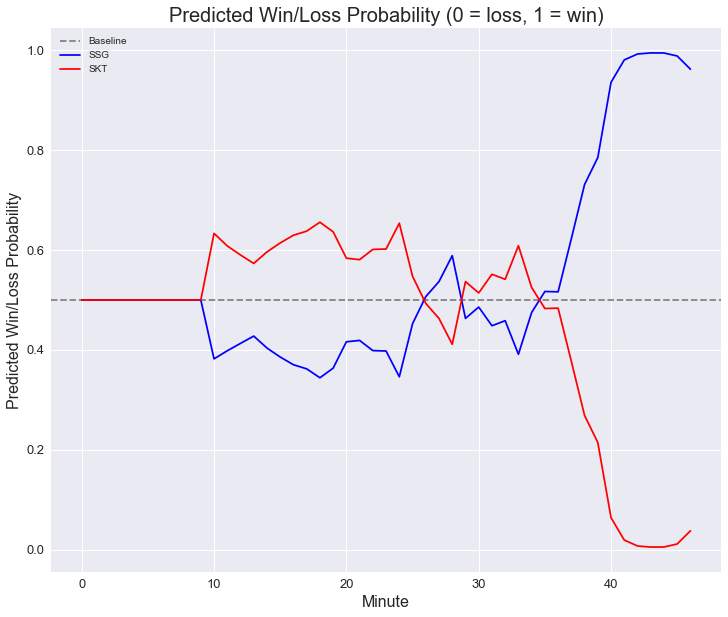

In [103]:
# create/format plot for predicted probabilities
# Game 4 of 2016 Championship
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
plt.axhline(y=0.5,label='Baseline', linestyle='--',color='gray')
plt.plot(ssg, color='b',label='SSG')
plt.plot(skt, color='r',label='SKT');
plt.title("Predicted Win/Loss Probability (0 = loss, 1 = win)",fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel("Minute", fontsize=16)
plt.legend()
plt.ylabel("Predicted Win/Loss Probability", fontsize=16);

## Conclusion

League of Legends has turned into a fascinating game and industry. Its immense popularity has steadily grown since the initial release in October 2009 into the gaming juggernaut LOL is today. In the past week (as of this writing) new teams owned and operated by NBA/MLB owners have joined the professional league, including the owners of the Golden State Warriors and Cleveland Cavs. These owners bring a level of funding and proven processes previously unseen in video game e-sports. Additionally, Disney-owned BAMTech has inked a $300 million deal to exclusively stream LOL to the world. At this point it is hard to say exactly how popular LOL could possibly be, but powerful, successful businesses have high hopes.

The model created here, as well as the EDA, were not created in a vacuum. There is significant money up for grabs in League of Legends. The winners will likely be those that make the most effective use of the data. For teams, this model could be used to mold their players to play a certain style of LOL, a style pulled from the data to maximize effectiveness and the team's chance to win. For outsiders, a model and EDA analysis like the ones here could one day be used to inform betting decisions. 

While e-sports was the chosen topic for this project, the underlying idea was to find a business use case for machine learning. By themselves, predictive models are simply representations of data. It is up to the people that create them to find the stakeholder value they hold within.